# Prédictions du genre d'un film

## 1. Récupération des genres

Permet de récupérer les labels qui seront mis dans une array

In [1]:
import ast
import pandas as pd
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.preprocessing.sequence import pad_sequences
pd.options.mode.chained_assignment = None
import argparse
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import cv2
from math import floor

Using TensorFlow backend.


In [2]:
#we take the years from 2000 to 2018
years = range(2000, 2019)

In [3]:
#we take the spectrums we got
list_of_eligible_spectrums = []
for year in years:
    for file in os.listdir("./spectrumImages/SpectrumImages" + str(year)):
        if str(file)[-4:] == '.jpg':
            list_of_eligible_spectrums += ['SpectrumImages'+ str(year) +'/' + file]

> We select 3 genres : Action, Comedy and Drama

The initial genres are:

{"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]}

In [4]:
#Here we create a dictionary with the link and its genre

genres = [28, 35, 18, 99, 10749, 10752, 10402, 53, 878, 27, 9648, 80, 14, 12, 36, 10769, 16, 10751, 37, 10770]

wanted_genres = {28: 'action', 35: 'comedy', 18: 'drama', 99: 0, 10749: 'comedy',10752: 'action', 10402: 0, 53: 'action', 878: 'action', 27: 'action', 9648: 'action', 80: 'action', 14: 'action', 12: 'action', 36: 0, 10769: 0, 16: 0, 10751: 0, 37: 'action', 10770: 0}


def get_genre_from_link():
    dict_inverse = {}
    links_to_be_removed = []
    for year in years:
        path = "./Link-dictionaries/Link-dictionary" + str(year)+ ".txt"
        file = open(path, "r").read()
        dictyear = ast.literal_eval(file)
        for movie_id in dictyear.keys():
            if dictyear[movie_id][1] != []:
                dict_inverse[str(dictyear[movie_id][2])] = {}
                movie_genres = dictyear[movie_id][1]
                if wanted_genres[movie_genres[0]] != 0:
                        dict_inverse[str(dictyear[movie_id][2])]['genre'] = wanted_genres[movie_genres[0]]
                elif len(movie_genres)>1:
                    if wanted_genres[movie_genres[1]] != 0:
                        dict_inverse[str(dictyear[movie_id][2])]['genre'] = wanted_genres[movie_genres[1]]
                    elif len(movie_genres)>2:
                        if wanted_genres[movie_genres[2]] != 0:
                            dict_inverse[str(dictyear[movie_id][2])]['genre'] = wanted_genres[movie_genres[2]]
                        else:
                            links_to_be_removed += [dictyear[movie_id][2]]
                    else:
                        links_to_be_removed += [dictyear[movie_id][2]]
                else:
                    links_to_be_removed += [dictyear[movie_id][2]]
            else:
                links_to_be_removed += [dictyear[movie_id][2]]
    return dict_inverse, links_to_be_removed

def get_output_list(L):
    dict_inverse, links_to_be_removed = get_genre_from_link()
    eligible_links = []
    output = []
    for link in L:
        link = str(link)
        if link[-5] == ".":
            link = link[:-4] + link[-3:]
        if link.split('/')[1][:-4] not in links_to_be_removed:
            eligible_links += [link[:-4]]
    return dict_inverse, eligible_links


dict_inverse, eligible_links = get_output_list(list_of_eligible_spectrums)

## 2. Extraction des images

In [5]:
for file in eligible_links:
    img = cv2.imread('./SpectrumImages/'+ file + '.jpg', 1)
    try:
        img = img[0:1]
    except Exception as e:
        img = cv2.imread('./SpectrumImages/'+ file + '..jpg', 1)
        img = img[0:1]
    img = img.reshape((img.shape[1], img.shape[2]))
    if file.split('/')[1] in dict_inverse.keys():
        dict_inverse[file.split('/')[1]]['image'] = img

In [6]:
df = pd.DataFrame.from_dict(dict_inverse)
df = df.transpose()
df = df.reset_index(drop=True)
#we shuffle!
df = df.sample(frac=1)

In [7]:
df.shape

(33233, 2)

In [8]:
df2 = df.dropna(axis=0)

In [9]:
df2.shape

(18990, 2)

In [10]:
df2.groupby('genre').count()

image
genre        
action   8134
comedy   5004
drama    5852

## 3. Oversampling

> To ensure the symetry of the data we use the oversampling method

In [11]:
df_act = df2[df2['genre']=='action']
df_com = df2[df2['genre']=='comedy']
df_dra = df2[df2['genre']=='drama']

count_act = df_act.groupby('genre').count()
count_com = df_com.groupby('genre').count()
count_dra = df_dra.groupby('genre').count()

nb_act = count_act.iloc[0,0]
nb_com = count_com.iloc[0,0]
nb_dra = count_dra.iloc[0,0]

nb_max = max(nb_act,nb_com,nb_dra)

print(f"max number of spectrums for oversampling : {nb_max}")

#shuffling
df_act = df_act.sample(frac=1)
df_com = df_com.sample(frac=1)
df_dra = df_dra.sample(frac=1)

#adding data
df_act = df_act.append(df_act.iloc[:nb_max-nb_act, :])
df_com = df_com.append(df_com.iloc[:nb_max-nb_com, :])
df_dra = df_dra.append(df_dra.iloc[:nb_max-nb_dra, :])

#concatenate
df_sym=pd.concat([df_com,df_act,df_dra])
print(df_sym.groupby('genre').count())
df_sym = pd.get_dummies(df_sym,columns=['genre'])

max number of spectrums for oversampling : 8134
        image
genre        
action   8134
comedy   8134
drama    8134


In [12]:
#shuffle!!
df_sym = df_sym.sample(frac=1)

>We isolate the testing set

In [13]:
train_len = int(df_sym.shape[0]*0.8)
train_len

19521

In [14]:
train = df_sym.iloc[:train_len, :]
test = df_sym.iloc[train_len:, :]

In [15]:
train['image'].head()

13288    [[114, 109, 100], [25, 22, 8], [23, 20, 5], [3...
24473    [[51, 23, 42], [53, 21, 45], [51, 22, 45], [46...
8292     [[6, 2, 1], [6, 3, 0], [26, 25, 21], [54, 60, ...
25536    [[9, 2, 0], [7, 2, 0], [9, 6, 2], [17, 18, 14]...
5960     [[1, 6, 4], [121, 121, 115], [117, 111, 104], ...
Name: image, dtype: object

In [16]:
train.shape, test.shape

((19521, 4), (4881, 4))

In [17]:
X_train = train['image']
Y_train = train.drop('image', 1)
X_test = test['image']
Y_test = test.drop('image', 1)

## 4. Dernières mises en forme

> We use the pad_sequences method to ensure the uniformity of our data


In [18]:
#Détermination du plus grand vecteur
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)
max_len = max(X_train.shape[1] , X_test.shape[1])

In [19]:
#padding final
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [20]:
input_shapeA = (X_train.shape[1], X_train.shape[2])
input_shapeA

(2474, 3)

## 5. Modèles

 ### 5.1 MLP

> ### MLP - Construction du modèle

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten

num_classes=3


#defining the layers architecture

model_MLP = Sequential()
model_MLP.add(Dense(20, input_shape=input_shapeA, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Flatten())
model_MLP.add(Dense(num_classes, activation='softmax'))

In [23]:
model_MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2474, 20)          80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 2474, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 49480)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 148443    
Total params: 148,523
Trainable params: 148,523
Non-trainable params: 0
_________________________________________________________________


> ### MLP - Entrainement du modèle

In [24]:
model_MLP.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_MLP = model_MLP.fit(X_train, Y_train, epochs=300, validation_split=0.3, batch_size=400 , verbose=1)

Train on 13664 samples, validate on 5857 samples
Epoch 1/300
13664/13664 [==============================] - 16s 1ms/step - loss: 10.2848 - acc: 0.3409 - val_loss: 10.4055 - val_acc: 0.3418
Epoch 2/300
13664/13664 [==============================] - 19s 1ms/step - loss: 10.0707 - acc: 0.3525 - val_loss: 9.4584 - val_acc: 0.3724
Epoch 3/300
13664/13664 [==============================] - 17s 1ms/step - loss: 9.0090 - acc: 0.3964 - val_loss: 8.9553 - val_acc: 0.3886
Epoch 4/300
13664/13664 [==============================] - 21s 2ms/step - loss: 8.7070 - acc: 0.3967 - val_loss: 9.0624 - val_acc: 0.3707
Epoch 5/300
13664/13664 [==============================] - 16s 1ms/step - loss: 8.3817 - acc: 0.4066 - val_loss: 8.8587 - val_acc: 0.3731
Epoch 6/300
13664/13664 [==============================] - 16s 1ms/step - loss: 7.7819 - acc: 0.4132 - val_loss: 6.8496 - val_acc: 0.4093
Epoch 7/300
13664/13664 [==============================] - 14s 1ms/step - loss: 5.1190 - acc: 0.4442 - val_loss: 3.9225 

13664/13664 [==============================] - 15s 1ms/step - loss: 0.8120 - acc: 0.6357 - val_loss: 1.3609 - val_acc: 0.4637
Epoch 60/300
13664/13664 [==============================] - 17s 1ms/step - loss: 0.8257 - acc: 0.6281 - val_loss: 1.3528 - val_acc: 0.4690
Epoch 61/300
13664/13664 [==============================] - 13s 966us/step - loss: 0.8109 - acc: 0.6386 - val_loss: 1.3377 - val_acc: 0.4723
Epoch 62/300
13664/13664 [==============================] - 16s 1ms/step - loss: 0.8115 - acc: 0.6393 - val_loss: 1.4001 - val_acc: 0.4731
Epoch 63/300
13664/13664 [==============================] - 15s 1ms/step - loss: 0.8145 - acc: 0.6295 - val_loss: 1.3623 - val_acc: 0.4743
Epoch 64/300
13664/13664 [==============================] - 14s 1ms/step - loss: 0.8093 - acc: 0.6422 - val_loss: 1.3571 - val_acc: 0.4608
Epoch 65/300
13664/13664 [==============================] - 17s 1ms/step - loss: 0.8217 - acc: 0.6356 - val_loss: 1.3601 - val_acc: 0.4687
Epoch 66/300
13664/13664 [============

13664/13664 [==============================] - 13s 951us/step - loss: 0.7752 - acc: 0.6589 - val_loss: 1.4773 - val_acc: 0.4738
Epoch 118/300
13664/13664 [==============================] - 13s 981us/step - loss: 0.7676 - acc: 0.6593 - val_loss: 1.4915 - val_acc: 0.4816
Epoch 119/300
13664/13664 [==============================] - 13s 950us/step - loss: 0.7821 - acc: 0.6585 - val_loss: 1.4625 - val_acc: 0.4736
Epoch 120/300
13664/13664 [==============================] - 15s 1ms/step - loss: 0.7643 - acc: 0.6594 - val_loss: 1.4696 - val_acc: 0.4782
Epoch 121/300
13664/13664 [==============================] - 14s 1ms/step - loss: 0.7665 - acc: 0.6579 - val_loss: 1.4980 - val_acc: 0.4808
Epoch 122/300
13664/13664 [==============================] - 14s 989us/step - loss: 0.8335 - acc: 0.6515 - val_loss: 1.4911 - val_acc: 0.4803
Epoch 123/300
13664/13664 [==============================] - 21s 2ms/step - loss: 0.7810 - acc: 0.6552 - val_loss: 1.4701 - val_acc: 0.4767
Epoch 124/300
13664/13664 

13664/13664 [==============================] - 12s 903us/step - loss: 0.7397 - acc: 0.6734 - val_loss: 1.5240 - val_acc: 0.4775
Epoch 176/300
13664/13664 [==============================] - 14s 1ms/step - loss: 0.7380 - acc: 0.6772 - val_loss: 1.5543 - val_acc: 0.4753
Epoch 177/300
13664/13664 [==============================] - 13s 981us/step - loss: 0.7344 - acc: 0.6787 - val_loss: 1.5737 - val_acc: 0.4709
Epoch 178/300
13664/13664 [==============================] - 13s 917us/step - loss: 0.7380 - acc: 0.6740 - val_loss: 1.5445 - val_acc: 0.4760
Epoch 179/300
13664/13664 [==============================] - 12s 891us/step - loss: 0.7386 - acc: 0.6726 - val_loss: 1.5770 - val_acc: 0.4668
Epoch 180/300
13664/13664 [==============================] - 12s 867us/step - loss: 0.7365 - acc: 0.6750 - val_loss: 1.5563 - val_acc: 0.4794
Epoch 181/300
13664/13664 [==============================] - 12s 874us/step - loss: 0.7295 - acc: 0.6770 - val_loss: 1.5507 - val_acc: 0.4736
Epoch 182/300
13664/13

13664/13664 [==============================] - 14s 1ms/step - loss: 0.7265 - acc: 0.6848 - val_loss: 1.6196 - val_acc: 0.4709
Epoch 234/300
13664/13664 [==============================] - 14s 1ms/step - loss: 0.7092 - acc: 0.6850 - val_loss: 1.6104 - val_acc: 0.4767
Epoch 235/300
13664/13664 [==============================] - 13s 986us/step - loss: 0.7179 - acc: 0.6892 - val_loss: 1.6101 - val_acc: 0.4688
Epoch 236/300
13664/13664 [==============================] - 13s 976us/step - loss: 0.7147 - acc: 0.6838 - val_loss: 1.6125 - val_acc: 0.4680
Epoch 237/300
13664/13664 [==============================] - 14s 1ms/step - loss: 0.7094 - acc: 0.6887 - val_loss: 1.6365 - val_acc: 0.4777
Epoch 238/300
13664/13664 [==============================] - 13s 927us/step - loss: 0.7167 - acc: 0.6836 - val_loss: 1.6480 - val_acc: 0.4731
Epoch 239/300
13664/13664 [==============================] - 14s 1ms/step - loss: 0.7326 - acc: 0.6833 - val_loss: 1.6583 - val_acc: 0.4699
Epoch 240/300
13664/13664 [=

Epoch 291/300
13664/13664 [==============================] - 13s 945us/step - loss: 0.7089 - acc: 0.6912 - val_loss: 1.6609 - val_acc: 0.4726
Epoch 292/300
13664/13664 [==============================] - 13s 932us/step - loss: 0.7020 - acc: 0.6909 - val_loss: 1.6558 - val_acc: 0.4794
Epoch 293/300
13664/13664 [==============================] - 12s 900us/step - loss: 0.7058 - acc: 0.6916 - val_loss: 1.6802 - val_acc: 0.4714
Epoch 294/300
13664/13664 [==============================] - 12s 896us/step - loss: 0.7140 - acc: 0.6916 - val_loss: 1.6466 - val_acc: 0.4784
Epoch 295/300
13664/13664 [==============================] - 12s 875us/step - loss: 0.7258 - acc: 0.6901 - val_loss: 1.6799 - val_acc: 0.4799
Epoch 296/300
13664/13664 [==============================] - 12s 886us/step - loss: 0.7124 - acc: 0.6883 - val_loss: 1.6455 - val_acc: 0.4663
Epoch 297/300
13664/13664 [==============================] - 12s 883us/step - loss: 0.7027 - acc: 0.6879 - val_loss: 1.6693 - val_acc: 0.4721
Epoch 


  Année: range(2000, 2019)   //  Genre: action, comedy, drama  //  Données X_train: (19521, 2474, 3)



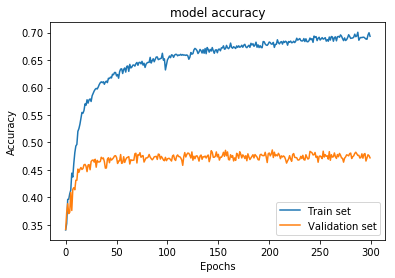

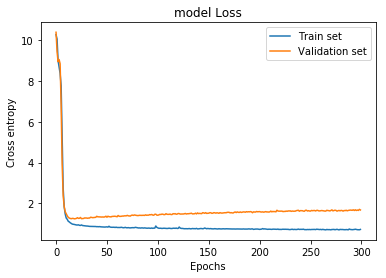

In [26]:
import matplotlib.pyplot as plt
train, =plt.plot(history_MLP.history['acc'], label='Train set')
val, =plt.plot(history_MLP.history['val_acc'], label='Validation set')
print('')
print(f"  Année: {years}   //  Genre: action, comedy, drama  //  Données X_train: {X_train.shape}")
print('')
plt.title('model accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epochs')
plt.legend(handles=[train, val])
plt.show()
train, =plt.plot(history_MLP.history['loss'], label='Train set')
val, =plt.plot(history_MLP.history['val_loss'], label='Validation set')
plt.title('model Loss')
plt.ylabel('Cross entropy')
plt.xlabel('Epochs')
plt.legend(handles=[train, val])
plt.show()

> ### MLP - Testing du modèle & résultats

In [25]:
predictions_MLP = model_MLP.predict(X_test)

Confusion matrix, without normalization
[[659 402 575]
 [278 884 447]
 [423 338 875]]
Normalized confusion matrix
[[ 0.4   0.25  0.35]
 [ 0.17  0.55  0.28]
 [ 0.26  0.21  0.53]]


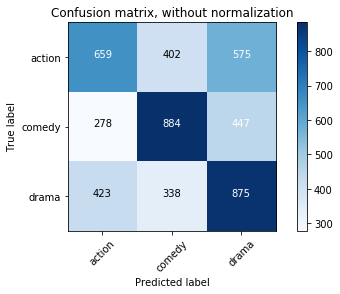

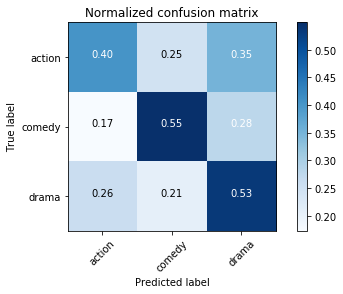

In [27]:
import itertools
len1 = predictions_MLP.shape[0]
predic = []
for i in range(len1):
    predic += [0] 
    pred = predictions_MLP[i]
    max_pred = 0
    for j in range(3):
        if pred[j] >= max_pred:
            max_pred = pred[j]
            predic[i] = j
truth = []
for i in range(len1):
    truthh = Y_test.values[i]
    for j in range(3):
        if truthh[j] == 1:
            truth += [j]

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['action', 'comedy', 'drama']

# Compute confusion matrix
cnf_matrix = confusion_matrix(truth, predic)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 5.2 CNN

> ### CNN - Construction du modèle

In [30]:
input_shapeA = (X_train.shape[1], X_train.shape[2])

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout, Average, BatchNormalization
from keras.layers import Flatten

num_classes=3

#Hyperparameters
filtersCNN1=2
kernelSize1=5

filtersCNN2=4
kernelSize2=5

unitsFC1=1000
unitsFC2=num_classes

#defining the layers architecture

model_CNN = Sequential()
model_CNN.add(Conv1D(filtersCNN1,kernelSize1,strides=2, padding="valid", activation='relu',input_shape=input_shapeA))
model_CNN.add(MaxPooling1D(pool_size=2,padding="valid"))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv1D(filtersCNN2,kernelSize2,strides=2, padding="valid", activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2,strides=None,padding="valid"))
model_CNN.add(Dropout(0.2))


model_CNN.add(Conv1D(filtersCNN2,kernelSize2,strides=2, padding="valid", activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2,strides=None,padding="valid"))

model_CNN.add(Flatten())
model_CNN.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [32]:
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1235, 2)           32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 617, 2)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 617, 2)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 307, 4)            44        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 4)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 153, 4)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 75, 4)             84        
__________

 > ### CNN - Entrainement du modèle

In [33]:
model_CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_CNN = model_CNN.fit(X_train, Y_train, epochs=500, validation_split=0.3, batch_size=100 , verbose=1)

Train on 13664 samples, validate on 5857 samples
Epoch 1/500
13664/13664 [==============================] - 6s 456us/step - loss: 1.7158 - acc: 0.3435 - val_loss: 1.1381 - val_acc: 0.3558
Epoch 2/500
13664/13664 [==============================] - 5s 346us/step - loss: 1.1248 - acc: 0.3825 - val_loss: 1.0970 - val_acc: 0.3879
Epoch 3/500
13664/13664 [==============================] - 5s 371us/step - loss: 1.0957 - acc: 0.3938 - val_loss: 1.0858 - val_acc: 0.4000
Epoch 4/500
13664/13664 [==============================] - 5s 335us/step - loss: 1.0878 - acc: 0.3928 - val_loss: 1.0813 - val_acc: 0.4058
Epoch 5/500
13664/13664 [==============================] - 5s 333us/step - loss: 1.0834 - acc: 0.3992 - val_loss: 1.0781 - val_acc: 0.4081
Epoch 6/500
13664/13664 [==============================] - 5s 359us/step - loss: 1.0799 - acc: 0.4043 - val_loss: 1.0758 - val_acc: 0.4070
Epoch 7/500
13664/13664 [==============================] - 5s 339us/step - loss: 1.0793 - acc: 0.4060 - val_loss: 1.0

13664/13664 [==============================] - 5s 374us/step - loss: 1.0522 - acc: 0.4375 - val_loss: 1.0585 - val_acc: 0.4379
Epoch 60/500
13664/13664 [==============================] - 5s 363us/step - loss: 1.0523 - acc: 0.4435 - val_loss: 1.0560 - val_acc: 0.4402
Epoch 61/500
13664/13664 [==============================] - 5s 364us/step - loss: 1.0517 - acc: 0.4423 - val_loss: 1.0617 - val_acc: 0.4350
Epoch 62/500
13664/13664 [==============================] - 5s 363us/step - loss: 1.0536 - acc: 0.4420 - val_loss: 1.0582 - val_acc: 0.4366
Epoch 63/500
13664/13664 [==============================] - 5s 369us/step - loss: 1.0502 - acc: 0.4428 - val_loss: 1.0592 - val_acc: 0.4364
Epoch 64/500
13664/13664 [==============================] - 5s 362us/step - loss: 1.0521 - acc: 0.4394 - val_loss: 1.0576 - val_acc: 0.4362
Epoch 65/500
13664/13664 [==============================] - 5s 363us/step - loss: 1.0517 - acc: 0.4416 - val_loss: 1.0562 - val_acc: 0.4410
Epoch 66/500
13664/13664 [=======

13664/13664 [==============================] - 5s 377us/step - loss: 1.0456 - acc: 0.4449 - val_loss: 1.0580 - val_acc: 0.4398
Epoch 118/500
13664/13664 [==============================] - 5s 363us/step - loss: 1.0457 - acc: 0.4447 - val_loss: 1.0589 - val_acc: 0.4424
Epoch 119/500
13664/13664 [==============================] - 6s 446us/step - loss: 1.0458 - acc: 0.4457 - val_loss: 1.0586 - val_acc: 0.4405
Epoch 120/500
13664/13664 [==============================] - 5s 390us/step - loss: 1.0446 - acc: 0.4475 - val_loss: 1.0607 - val_acc: 0.4306
Epoch 121/500
13664/13664 [==============================] - 5s 370us/step - loss: 1.0446 - acc: 0.4502 - val_loss: 1.0580 - val_acc: 0.4393
Epoch 122/500
13664/13664 [==============================] - 6s 427us/step - loss: 1.0458 - acc: 0.4435 - val_loss: 1.0611 - val_acc: 0.4355
Epoch 123/500
13664/13664 [==============================] - 6s 455us/step - loss: 1.0459 - acc: 0.4471 - val_loss: 1.0578 - val_acc: 0.4434
Epoch 124/500
13664/13664 [

13664/13664 [==============================] - 5s 337us/step - loss: 1.0436 - acc: 0.4510 - val_loss: 1.0543 - val_acc: 0.4415
Epoch 176/500
13664/13664 [==============================] - 6s 462us/step - loss: 1.0422 - acc: 0.4492 - val_loss: 1.0540 - val_acc: 0.4470
Epoch 177/500
13664/13664 [==============================] - 5s 342us/step - loss: 1.0434 - acc: 0.4552 - val_loss: 1.0532 - val_acc: 0.4502
Epoch 178/500
13664/13664 [==============================] - 5s 375us/step - loss: 1.0456 - acc: 0.4483 - val_loss: 1.0535 - val_acc: 0.4456
Epoch 179/500
13664/13664 [==============================] - 5s 375us/step - loss: 1.0432 - acc: 0.4527 - val_loss: 1.0530 - val_acc: 0.4460
Epoch 180/500
13664/13664 [==============================] - 5s 354us/step - loss: 1.0436 - acc: 0.4522 - val_loss: 1.0547 - val_acc: 0.4427
Epoch 181/500
13664/13664 [==============================] - 5s 382us/step - loss: 1.0411 - acc: 0.4512 - val_loss: 1.0542 - val_acc: 0.4497
Epoch 182/500
13664/13664 [

13664/13664 [==============================] - 5s 361us/step - loss: 1.0361 - acc: 0.4589 - val_loss: 1.0464 - val_acc: 0.4552
Epoch 234/500
13664/13664 [==============================] - 5s 373us/step - loss: 1.0375 - acc: 0.4571 - val_loss: 1.0463 - val_acc: 0.4548
Epoch 235/500
13664/13664 [==============================] - 5s 360us/step - loss: 1.0376 - acc: 0.4582 - val_loss: 1.0472 - val_acc: 0.4514
Epoch 236/500
13664/13664 [==============================] - 5s 347us/step - loss: 1.0373 - acc: 0.4578 - val_loss: 1.0478 - val_acc: 0.4564
Epoch 237/500
13664/13664 [==============================] - 5s 367us/step - loss: 1.0374 - acc: 0.4567 - val_loss: 1.0458 - val_acc: 0.4513
Epoch 238/500
13664/13664 [==============================] - 5s 364us/step - loss: 1.0358 - acc: 0.4584 - val_loss: 1.0480 - val_acc: 0.4571
Epoch 239/500
13664/13664 [==============================] - 6s 419us/step - loss: 1.0377 - acc: 0.4565 - val_loss: 1.0445 - val_acc: 0.4615
Epoch 240/500
13664/13664 [

13664/13664 [==============================] - 5s 378us/step - loss: 1.0339 - acc: 0.4616 - val_loss: 1.0431 - val_acc: 0.4579
Epoch 292/500
13664/13664 [==============================] - 5s 388us/step - loss: 1.0341 - acc: 0.4563 - val_loss: 1.0475 - val_acc: 0.4518
Epoch 293/500
13664/13664 [==============================] - 6s 408us/step - loss: 1.0362 - acc: 0.4582 - val_loss: 1.0457 - val_acc: 0.4552
Epoch 294/500
13664/13664 [==============================] - 6s 462us/step - loss: 1.0343 - acc: 0.4615 - val_loss: 1.0439 - val_acc: 0.4554
Epoch 295/500
13664/13664 [==============================] - 6s 409us/step - loss: 1.0367 - acc: 0.4584 - val_loss: 1.0466 - val_acc: 0.4518
Epoch 296/500
13664/13664 [==============================] - 6s 420us/step - loss: 1.0366 - acc: 0.4646 - val_loss: 1.0443 - val_acc: 0.4572
Epoch 297/500
13664/13664 [==============================] - 6s 409us/step - loss: 1.0356 - acc: 0.4587 - val_loss: 1.0455 - val_acc: 0.4550
Epoch 298/500
13664/13664 [

13664/13664 [==============================] - 7s 511us/step - loss: 1.0350 - acc: 0.4603 - val_loss: 1.0487 - val_acc: 0.4478
Epoch 350/500
13664/13664 [==============================] - 6s 475us/step - loss: 1.0347 - acc: 0.4604 - val_loss: 1.0483 - val_acc: 0.4518
Epoch 351/500
13664/13664 [==============================] - 5s 380us/step - loss: 1.0346 - acc: 0.4571 - val_loss: 1.0491 - val_acc: 0.4494
Epoch 352/500
13664/13664 [==============================] - 5s 374us/step - loss: 1.0345 - acc: 0.4539 - val_loss: 1.0500 - val_acc: 0.4470
Epoch 353/500
13664/13664 [==============================] - 5s 387us/step - loss: 1.0326 - acc: 0.4644 - val_loss: 1.0479 - val_acc: 0.4516
Epoch 354/500
13664/13664 [==============================] - 5s 356us/step - loss: 1.0349 - acc: 0.4619 - val_loss: 1.0477 - val_acc: 0.4530
Epoch 355/500
13664/13664 [==============================] - 5s 360us/step - loss: 1.0317 - acc: 0.4608 - val_loss: 1.0482 - val_acc: 0.4525
Epoch 356/500
13664/13664 [

13664/13664 [==============================] - 5s 366us/step - loss: 1.0346 - acc: 0.4614 - val_loss: 1.0520 - val_acc: 0.4501
Epoch 408/500
13664/13664 [==============================] - 5s 359us/step - loss: 1.0343 - acc: 0.4636 - val_loss: 1.0484 - val_acc: 0.4571
Epoch 409/500
13664/13664 [==============================] - 5s 356us/step - loss: 1.0335 - acc: 0.4626 - val_loss: 1.0482 - val_acc: 0.4530
Epoch 410/500
13664/13664 [==============================] - 5s 353us/step - loss: 1.0335 - acc: 0.4632 - val_loss: 1.0496 - val_acc: 0.4470
Epoch 411/500
13664/13664 [==============================] - 5s 342us/step - loss: 1.0341 - acc: 0.4620 - val_loss: 1.0529 - val_acc: 0.4504
Epoch 412/500
13664/13664 [==============================] - 5s 352us/step - loss: 1.0352 - acc: 0.4636 - val_loss: 1.0504 - val_acc: 0.4484
Epoch 413/500
13664/13664 [==============================] - 5s 364us/step - loss: 1.0360 - acc: 0.4660 - val_loss: 1.0482 - val_acc: 0.4540
Epoch 414/500
13664/13664 [

13664/13664 [==============================] - 6s 404us/step - loss: 1.0342 - acc: 0.4612 - val_loss: 1.0500 - val_acc: 0.4536
Epoch 466/500
13664/13664 [==============================] - 5s 382us/step - loss: 1.0330 - acc: 0.4674 - val_loss: 1.0513 - val_acc: 0.4542
Epoch 467/500
13664/13664 [==============================] - 6s 427us/step - loss: 1.0345 - acc: 0.4627 - val_loss: 1.0482 - val_acc: 0.4550
Epoch 468/500
13664/13664 [==============================] - 6s 409us/step - loss: 1.0337 - acc: 0.4627 - val_loss: 1.0525 - val_acc: 0.4583
Epoch 469/500
13664/13664 [==============================] - 6s 411us/step - loss: 1.0334 - acc: 0.4649 - val_loss: 1.0499 - val_acc: 0.4581
Epoch 470/500
13664/13664 [==============================] - 5s 391us/step - loss: 1.0366 - acc: 0.4651 - val_loss: 1.0555 - val_acc: 0.4548
Epoch 471/500
13664/13664 [==============================] - 5s 401us/step - loss: 1.0343 - acc: 0.4650 - val_loss: 1.0505 - val_acc: 0.4557
Epoch 472/500
13664/13664 [


  Année: range(2000, 2019)   //  Genre: action, comedy, drama  //  Données X_train: (19521, 2474, 3)



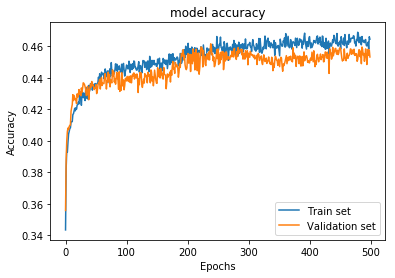

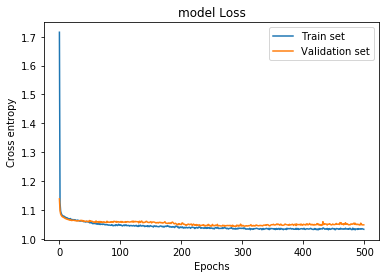

In [34]:
import matplotlib.pyplot as plt
train, =plt.plot(history_CNN.history['acc'], label='Train set')
val, =plt.plot(history_CNN.history['val_acc'], label='Validation set')
print('')
print(f"  Année: {years}   //  Genre: action, comedy, drama  //  Données X_train: {X_train.shape}")
print('')
plt.title('model accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epochs')
plt.legend(handles=[train, val])
plt.show()
train, =plt.plot(history_CNN.history['loss'], label='Train set')
val, =plt.plot(history_CNN.history['val_loss'], label='Validation set')
plt.title('model Loss')
plt.ylabel('Cross entropy')
plt.xlabel('Epochs')
plt.legend(handles=[train, val])
plt.show()

> ### CNN - Testing du modèle & résultats

In [35]:
predictions_CNN = model_CNN.predict(X_test)

Confusion matrix, without normalization
[[923 393 320]
 [356 927 326]
 [586 645 405]]
Normalized confusion matrix
[[ 0.56  0.24  0.2 ]
 [ 0.22  0.58  0.2 ]
 [ 0.36  0.39  0.25]]


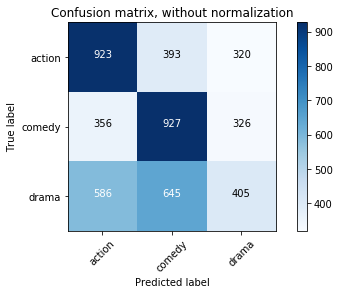

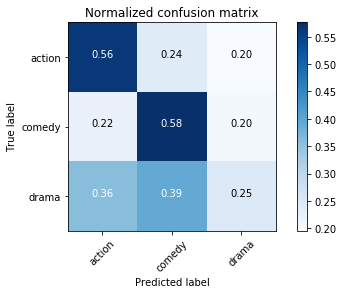

In [36]:
import itertools
len1 = predictions_CNN.shape[0]
predic = []
for i in range(len1):
    predic += [0] 
    pred = predictions_CNN[i]
    max_pred = 0
    for j in range(3):
        if pred[j] >= max_pred:
            max_pred = pred[j]
            predic[i] = j
truth = []
for i in range(len1):
    truthh = Y_test.values[i]
    for j in range(3):
        if truthh[j] == 1:
            truth += [j]

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['action', 'comedy', 'drama']

# Compute confusion matrix
cnf_matrix = confusion_matrix(truth, predic)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

 ### 5.3 LSTM

> ### LSTM - Construction du modèle

In [37]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout, Average, BatchNormalization
from keras.layers import Flatten

num_classes=3

#defining the layers architecture

model = Sequential()
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2,input_shape=input_shapeA))
model.add(Dense(num_classes, activation='softmax'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1920      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 1,983
Trainable params: 1,983
Non-trainable params: 0
_________________________________________________________________


> ### LSTM - Entrainement du modèle

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=100, validation_split=0.3, batch_size=100 , verbose=1)

Train on 13664 samples, validate on 5857 samples
Epoch 1/100
13664/13664 [==============================] - 267s 20ms/step - loss: 1.1082 - acc: 0.3560 - val_loss: 1.0905 - val_acc: 0.3708
Epoch 2/100
13664/13664 [==============================] - 258s 19ms/step - loss: 1.0956 - acc: 0.3708 - val_loss: 1.0854 - val_acc: 0.3744
Epoch 3/100
13664/13664 [==============================] - 262s 19ms/step - loss: 1.0852 - acc: 0.3858 - val_loss: 1.0802 - val_acc: 0.3836
Epoch 4/100
13664/13664 [==============================] - 232s 17ms/step - loss: 1.0815 - acc: 0.3980 - val_loss: 1.0775 - val_acc: 0.4028
Epoch 5/100
13664/13664 [==============================] - 229s 17ms/step - loss: 1.0725 - acc: 0.4076 - val_loss: 1.0666 - val_acc: 0.4157
Epoch 6/100
13664/13664 [==============================] - 230s 17ms/step - loss: 1.0683 - acc: 0.4071 - val_loss: 1.0602 - val_acc: 0.4198
Epoch 7/100
13664/13664 [==============================] - 229s 17ms/step - loss: 1.0645 - acc: 0.4134 - val_lo

Epoch 59/100
13664/13664 [==============================] - 227s 17ms/step - loss: 1.0471 - acc: 0.4453 - val_loss: 1.0434 - val_acc: 0.4499
Epoch 60/100
13664/13664 [==============================] - 227s 17ms/step - loss: 1.0534 - acc: 0.4385 - val_loss: 1.0892 - val_acc: 0.3944
Epoch 61/100
13664/13664 [==============================] - 225s 16ms/step - loss: 1.0726 - acc: 0.4132 - val_loss: 1.0516 - val_acc: 0.4492
Epoch 62/100
13664/13664 [==============================] - 228s 17ms/step - loss: 1.0565 - acc: 0.4366 - val_loss: 1.0520 - val_acc: 0.4495
Epoch 63/100
13664/13664 [==============================] - 226s 17ms/step - loss: 1.0576 - acc: 0.4355 - val_loss: 1.0508 - val_acc: 0.4472
Epoch 64/100
13664/13664 [==============================] - 226s 17ms/step - loss: 1.0592 - acc: 0.4361 - val_loss: 1.0531 - val_acc: 0.4424
Epoch 65/100
13664/13664 [==============================] - 225s 16ms/step - loss: 1.0641 - acc: 0.4274 - val_loss: 1.0522 - val_acc: 0.4436
Epoch 66/100



  Année: range(2000, 2019)   //  Genre: action, comedy, drama  //  Données X_train: (19521, 2474, 3)



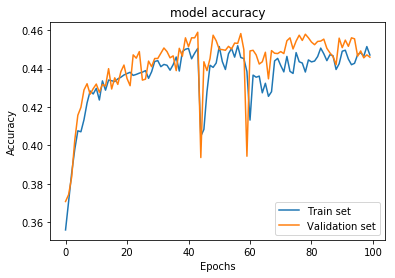

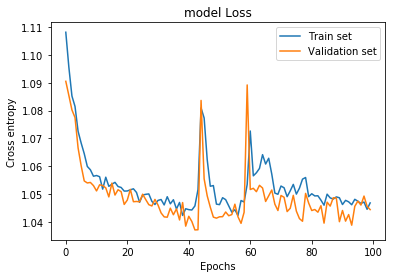

In [40]:
import matplotlib.pyplot as plt
train, =plt.plot(history.history['acc'], label='Train set')
val, =plt.plot(history.history['val_acc'], label='Validation set')
print('')
print(f"  Année: {years}   //  Genre: action, comedy, drama  //  Données X_train: {X_train.shape}")
print('')
plt.title('model accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epochs')
plt.legend(handles=[train, val])
plt.show()
train, =plt.plot(history.history['loss'], label='Train set')
val, =plt.plot(history.history['val_loss'], label='Validation set')
plt.title('model Loss')
plt.ylabel('Cross entropy')
plt.xlabel('Epochs')
plt.legend(handles=[train, val])
plt.show()

> ### LSTM - Testing du modèle & résultats

In [41]:
predictions_LSTM = model.predict(X_test)

Confusion matrix, without normalization
[[ 907  549  180]
 [ 401 1068  140]
 [ 802  622  212]]
Normalized confusion matrix
[[ 0.55  0.34  0.11]
 [ 0.25  0.66  0.09]
 [ 0.49  0.38  0.13]]


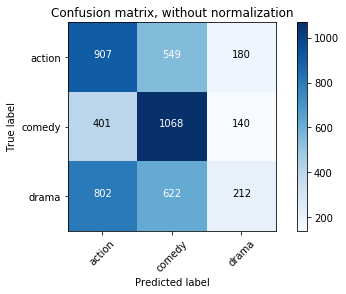

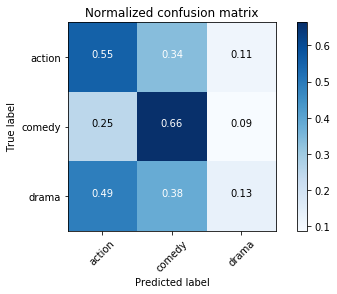

In [42]:
import itertools
len1 = predictions_LSTM.shape[0]
predic = []
for i in range(len1):
    predic += [0] 
    pred = predictions_LSTM[i]
    max_pred = 0
    for j in range(3):
        if pred[j] >= max_pred:
            max_pred = pred[j]
            predic[i] = j
truth = []
for i in range(len1):
    truthh = Y_test.values[i]
    for j in range(3):
        if truthh[j] == 1:
            truth += [j]

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['action', 'comedy', 'drama']

# Compute confusion matrix
cnf_matrix = confusion_matrix(truth, predic)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()